In [1]:
import pandas as pd
import stanza
import string
import re
import joblib
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn_crfsuite import CRF, metrics

from sklearn_crfsuite.metrics import flat_classification_report
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [48]:
# Membaca file dengan format seperti di atas
df = pd.read_csv("NERSkill.Id.txt", sep='\t', engine='python')

# Isi 'Sentence #' yang kosong diisi dengan nilai sebelumnya
df['Sentence #'] = df['Sentence #'].ffill()
df = df[~df["Word"].str.fullmatch(rf"[{re.escape(string.punctuation)}]+")]
df["Word"] = df["Word"].str.replace(rf"[{string.punctuation}]", "", regex=True)
df = df.reset_index(drop=True)


In [49]:
df.head(30)

,Sentence #,Word,Tag
0,sentence 411,Pendidikan,O
1,sentence 411,minimal,O
2,sentence 411,S1,O
3,sentence 411,dari,O
4,sentence 411,Jurusan,O
5,sentence 411,Teknik,O
6,sentence 411,Informatika,O
7,sentence 411,Ilmu,O
8,sentence 411,Komputer,O
9,sentence 411,Sistem,O


In [54]:
stanza.download('id')  # hanya sekali
nlp = stanza.Pipeline('id', processors='tokenize,pos', use_gpu=False, tokenize_pretokenized=True)

2025-08-06 08:58:24 INFO: Downloaded file to C:\Users\widi arsa\stanza_resources\resources.json
2025-08-06 08:58:24 INFO: Downloading default packages for language: id (Indonesian) ...
2025-08-06 08:58:24 INFO: File exists: C:\Users\widi arsa\stanza_resources\id\default.zip
2025-08-06 08:58:27 INFO: Finished downloading models and saved to C:\Users\widi arsa\stanza_resources
2025-08-06 08:58:27 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-08-06 08:58:27 INFO: Downloaded file to C:\Users\widi arsa\stanza_resources\resources.json
2025-08-06 08:58:27 INFO: Loading these models for language: id (Indonesian):
| Processor | Package    |
--------------------------
| tokenize  | gsd        |
| pos       | gsd_charlm |

2025-08-06 08:58:27 INFO: Using device: cpu
2025-08-06 08:58:27 INFO: Loading: tokenize
2025-08-06 08:58:27 INFO: Loading: pos
2025-08-06 08:58:29 INFO: Done loading processors!


In [55]:
pos_tags = []

# 4. Loop per kalimat
for sent_id, group in df.groupby("Sentence #"):
    words = group["Word"].tolist()
    sentence = " ".join(words)
    
    # POS tagging dengan stanza
    doc = nlp(sentence)
    tags = [word.pos for sent in doc.sentences for word in sent.words]

    # Validasi jumlah POS = jumlah kata
    if len(tags) != len(group):
        print(f"[WARNING] POS mismatch pada kalimat: {sent_id}")
        print("Kalimat :", sentence)
        print("Token DF:", words)
        print("Token NLP:", [word.text for s in doc.sentences for word in s.words])
        print("POS Tags:", tags)
        raise ValueError(f"Mismatch POS length for sentence: {sent_id}")
    
    pos_tags.extend(tags)

# 5. Tambahkan ke dataframe
df["POS"] = pos_tags

In [18]:
df = pd.read_pickle('data_train_skill_ner.pkl')

In [20]:
df.head()

,Sentence #,Word,Tag,POS
0,sentence 411,Pendidikan,O,NOUN
1,sentence 411,minimal,O,NOUN
2,sentence 411,S1,O,VERB
3,sentence 411,dari,O,CCONJ
4,sentence 411,Jurusan,O,VERB


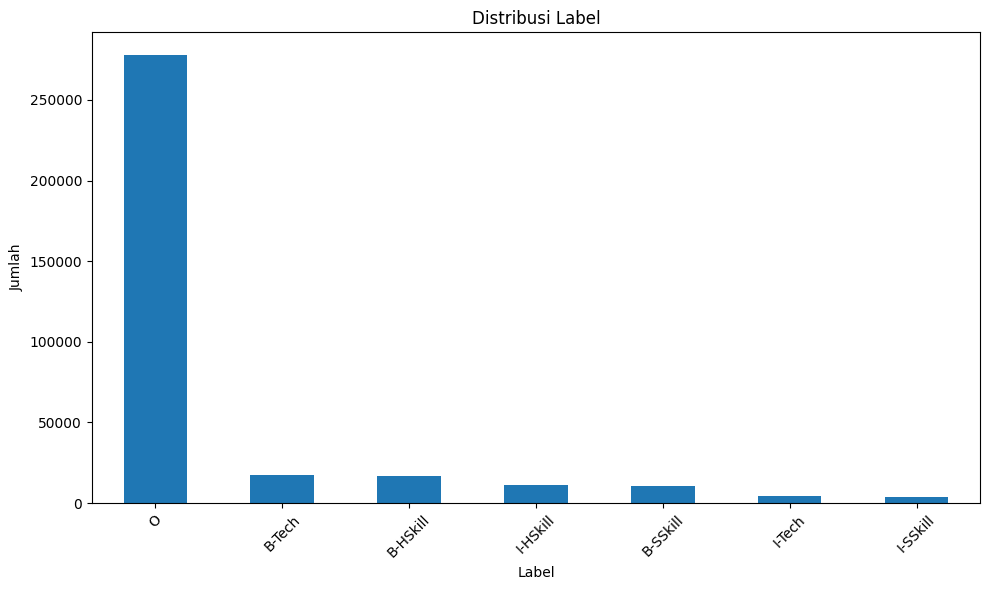

In [24]:
label_counts = df['Tag'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title("Distribusi Label")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
df = df.dropna(subset=['Sentence #', 'Word', 'Tag', 'POS'])

# Kelompokkan berdasarkan kalimat
grouped = df.groupby('Sentence #')

# Buat array 2D
sentences = []
for sent_id, group in grouped:
    triplets = group[['Word', 'Tag', 'POS']].values.tolist()
    sentences.append(triplets)

In [58]:
sentences[0]

[['Tanggung', 'O', 'PROPN'],
 ['jawab', 'O', 'VERB'],
 ['Mengelola', 'O', 'NOUN'],
 ['dan', 'O', 'ADJ'],
 ['memastikan', 'O', 'CCONJ'],
 ['semua', 'O', 'NOUN'],
 ['program', 'O', 'NOUN'],
 ['aplikasi', 'O', 'AUX'],
 ['memenuhi', 'O', 'VERB'],
 ['persyaratan', 'O', 'NOUN'],
 ['dokumentasi', 'O', 'PROPN'],
 ['dan', 'O', 'PROPN'],
 ['prosedur', 'O', 'VERB'],
 ['standar', 'O', 'PROPN'],
 ['Berkomunikasi', 'O', 'PROPN'],
 ['dengan', 'O', 'PROPN'],
 ['analis', 'O', 'PROPN'],
 ['bisnis', 'O', 'PROPN'],
 ['untuk', 'O', 'PROPN'],
 ['klarifikasi', 'O', 'VERB'],
 ['spesifikasi', 'O', 'NOUN'],
 ['teknis', 'O', 'NOUN'],
 ['pengujian', 'O', 'CCONJ'],
 ['dan', 'O', 'NOUN'],
 ['pelaporan', 'O', 'PRON'],
 ['kesalahan', 'O', 'ADJ'],
 ['yang', 'O', 'VERB'],
 ['ditemukan', 'O', 'PROPN'],
 ['dalam', 'O', 'PROPN'],
 ['sistem', 'O', 'VERB'],
 ['yang', 'O', 'NOUN'],
 ['didukung', 'O', 'NOUN'],
 ['Merancang', 'B-HSkill', 'ADP'],
 ['dan', 'O', 'NOUN'],
 ['mengembangkan', 'B-HSkill', 'NOUN'],
 ['program', 'I-HSk

In [ ]:
def word2features(sentence, i):
    word = sentence[i][0]
    pos = sentence[i][2]    
    features = {
        'word': word,
        'pos': pos,
        'is_first': i == 0, #if the word is a first word
        'is_last': i == len(sentence) - 1,  #if the word is a last word
        'is_capitalized': word[0].upper() == word[0],
        'is_all_caps': word.upper() == word,      #word is in uppercase
        'is_all_lower': word.lower() == word,      #word is in lowercase
         #prefix of the word
        'prefix-1': word[0],   
        'prefix-2': word[:2],
        'prefix-3': word[:3],
         #suffix of the word
        'suffix-1': word[-1],
        'suffix-2': word[-2:],
        'suffix-3': word[-3:],
         #extracting previous word
        'prev_word': '' if i == 0 else sentence[i-1][0],
        'prev_pos': '' if i == 0 else sentence[i-1][1],
         #extracting next word
        'next_word': '' if i == len(sentence)-1 else sentence[i+1][0],
        'next_pos': '' if i == len(sentence)-1 else sentence[i+1][1],
        'is_numeric': word.isdigit(),  #if word is in numeric
        'capitals_inside': word[1:].lower() != word[1:]
    }
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for _, label, _ in sent]

In [69]:
X = []
y = []

for i in range(len(sentences)):
    X.append(sent2features(sentences[i]))
    y.append(sent2labels(sentences[i]))

In [61]:
split_data = round(len(sentences)*0.8)
train_data_bio = X[:split_data]
train_y_bio = y[:split_data]

test_data_bio = X[split_data:]
test_y_bio = y[split_data:]

In [ ]:
c1_list = [0.0001,0.001, 0.01, 0.1]
c2_list = [0.0001,0.001, 0.01, 0.1]
param_combinations = list(itertools.product(c1_list, c2_list))

results = []

kf = KFold(n_splits=3, shuffle=True, random_state=42)
best_model = None
best_f1 = 0.0
best_y_test = []
best_y_pred = []

print("⏳ Mulai evaluasi semua kombinasi c1 & c2...\n")

for c1, c2 in param_combinations:
    print(f"🔍 Evaluasi: c1={c1}, c2={c2}")
    f1_scores, accuracies, precisions, recalls = [], [], [], []

    for train_index, test_index in kf.split(X):
        X_tr = [X[i] for i in train_index]
        y_tr = [y[i] for i in train_index]
        X_te = [X[i] for i in test_index]
        y_te = [y[i] for i in test_index]

        crf = CRF(
            algorithm='lbfgs',
            max_iterations=100,
            all_possible_transitions=True,
            c1=c1,
            c2=c2
        )

        crf.fit(X_tr, y_tr)
        y_pred = crf.predict(X_te)

        # Evaluasi
        f1 = metrics.flat_f1_score(y_te, y_pred, average='weighted')
        acc = metrics.flat_accuracy_score(y_te, y_pred)
        report = metrics.flat_classification_report(y_te, y_pred, output_dict=True, zero_division=0)
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']

        f1_scores.append(f1)
        accuracies.append(acc)
        precisions.append(precision)
        recalls.append(recall)

        if f1 > best_f1:
            best_f1 = f1
            best_model = crf
            best_y_test = y_te
            best_y_pred = y_pred

    results.append({
        'c1': c1,
        'c2': c2,
        'f1_score': np.mean(f1_scores),
        'accuracy': np.mean(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
    })

# Convert ke DataFrame dan simpan
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='f1_score', ascending=False)

# Tampilkan semua
print("\n Hasil Evaluasi Semua Kombinasi:")
print(df_results)



In [76]:
# Simpan ke file
df_results.to_csv('grid_search_crf_report.csv', index=False)
print("\n Disimpan ke file: grid_search_crf_report.csv")

with open("best_crf_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
print("\n Model disimpan ke file: best_crf_model.pkl")


 Disimpan ke file: grid_search_crf_report.csv

 Model disimpan ke file: best_crf_model.pkl


              precision    recall  f1-score   support

           O       0.98      0.99      0.98     94264
    B-HSkill       0.88      0.80      0.84      5761
    I-HSkill       0.88      0.92      0.90      3904
    B-SSkill       0.89      0.88      0.89      3662
      B-Tech       0.93      0.92      0.92      5870
      I-Tech       0.86      0.82      0.84      1489
    I-SSkill       0.93      0.94      0.93      1272

    accuracy                           0.97    116222
   macro avg       0.91      0.90      0.90    116222
weighted avg       0.97      0.97      0.97    116222



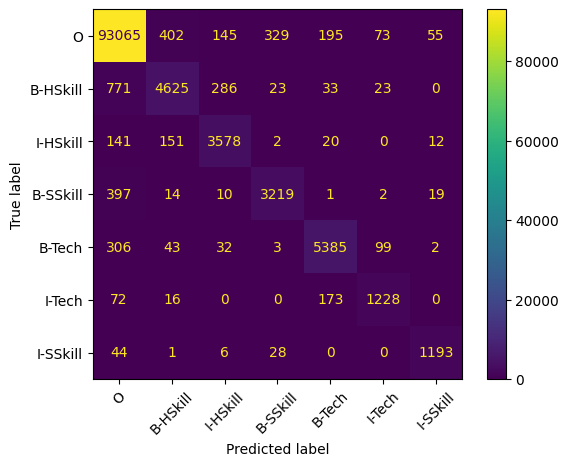

In [78]:
labels = list(best_model.classes_)

# Membuat confusion matrix (hati-hati: ini per-token, bukan per-sequence)
y_test_flat = [label for seq in best_y_test for label in seq]
y_pred_flat = [label for seq in best_y_pred for label in seq]
print(classification_report(y_test_flat, y_pred_flat, labels=labels))

cm = confusion_matrix(y_test_flat, y_pred_flat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [2]:
crf = joblib.load('best_crf_model.pkl')

In [5]:
nlp = stanza.Pipeline('id', processors='tokenize,pos', use_gpu=False, tokenize_pretokenized=True)

2025-08-06 12:52:11 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-08-06 12:52:12 INFO: Downloaded file to C:\Users\widi arsa\stanza_resources\resources.json
2025-08-06 12:52:12 INFO: Loading these models for language: id (Indonesian):
| Processor | Package    |
--------------------------
| tokenize  | gsd        |
| pos       | gsd_charlm |

2025-08-06 12:52:12 INFO: Using device: cpu
2025-08-06 12:52:12 INFO: Loading: tokenize
2025-08-06 12:52:12 INFO: Loading: pos
2025-08-06 12:52:13 INFO: Done loading processors!


In [13]:
senten_te = 'memahami dasar pemograman'


doc = nlp(senten_te)
tags = [word.pos for sent in doc.sentences for word in sent.words]


y = list(zip(senten_te.split(), tags))
y_feats = sent2features(y)
y_feats

[{'word': 'memahami',
  'pos': 'VERB',
  'is_first': True,
  'is_last': False,
  'is_capitalized': False,
  'is_all_caps': False,
  'is_all_lower': True,
  'prefix-1': 'm',
  'prefix-2': 'me',
  'prefix-3': 'mem',
  'suffix-1': 'i',
  'suffix-2': 'mi',
  'suffix-3': 'ami',
  'prev_word': '',
  'prev_pos': '',
  'next_word': 'dasar',
  'next_pos': 'NOUN',
  'is_numeric': False,
  'capitals_inside': False},
 {'word': 'dasar',
  'pos': 'NOUN',
  'is_first': False,
  'is_last': False,
  'is_capitalized': False,
  'is_all_caps': False,
  'is_all_lower': True,
  'prefix-1': 'd',
  'prefix-2': 'da',
  'prefix-3': 'das',
  'suffix-1': 'r',
  'suffix-2': 'ar',
  'suffix-3': 'sar',
  'prev_word': 'memahami',
  'prev_pos': 'VERB',
  'next_word': 'pemograman',
  'next_pos': 'NOUN',
  'is_numeric': False,
  'capitals_inside': False},
 {'word': 'pemograman',
  'pos': 'NOUN',
  'is_first': False,
  'is_last': True,
  'is_capitalized': False,
  'is_all_caps': False,
  'is_all_lower': True,
  'prefix-1

In [14]:
crf.predict([y_feats])

array([['O', 'O', 'B-HSkill']], dtype=object)